In [1]:
!sudo apt-get update >& /dev/null
!apt-get install -y xvfb x11-utils >& /dev/null
!pip install gym==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* >& /dev/null
!pip install stable-baselines3 >& /dev/null
!pip install highway-env

     |████████████████████████████████| 92kB 6.3MB/s 
     |████████████████████████████████| 11.8MB 13.3MB/s 


In [15]:
!rm -rf ./video
!mkdir -p ./video 

In [9]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1368, 768))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1368x768x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1368x768x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [13]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 256px;"> <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [2]:
import gym
import highway_env
import numpy as np

from stable_baselines3 import HER, SAC, DDPG
from stable_baselines3.common.noise import NormalActionNoise

In [3]:
env = gym.make("parking-v0")

In [4]:
# SAC hyperparams:
model = HER('MlpPolicy', env, SAC, n_sampled_goal=4,
            goal_selection_strategy='future', online_sampling=True,
            verbose=1, buffer_size=int(1e6),
            learning_rate=1e-3,
            gamma=0.95, batch_size=256,
            policy_kwargs=dict(net_arch=[256, 256, 256]), max_episode_length=100)

Using cuda device


In [5]:
# Train for 1e5 steps
model.learn(int(1e5))
# Save the trained agent
model.save('her_sac_parking')

Streaming output truncated to the last 5000 lines.
|    success rate    | 0.99     |
| time/              |          |
|    episodes        | 1752     |
|    fps             | 43       |
|    time_elapsed    | 1653     |
|    total timesteps | 71942    |
| train/             |          |
|    actor_loss      | 1.61     |
|    critic_loss     | 0.0103   |
|    ent_coef        | 0.00636  |
|    ent_coef_loss   | 0.72     |
|    learning_rate   | 0.001    |
|    n_updates       | 71841    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | -7.18    |
|    success rate    | 0.99     |
| time/              |          |
|    episodes        | 1756     |
|    fps             | 43       |
|    time_elapsed    | 1656     |
|    total timesteps | 72036    |
| train/             |          |
|    actor_loss      | 1.53     |
|    critic_loss     | 0.0247   |
|    ent_coef        | 0.00633 

In [17]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecVideoRecorder
from tqdm.notebook import trange

video_length = 1000

env = gym.make("parking-v0")
env = DummyVecEnv([lambda: env])

obs = env.reset()

env = VecVideoRecorder(env, './video/', record_video_trigger=lambda x: True, video_length=video_length)

loaded_model = HER.load('her_sac_parking', env=env)

for _ in trange(video_length + 1, desc="Generate video frames"):
  action, _ = loaded_model.predict(obs, deterministic=False)
  obs, _, _, _ = env.step(action)
  env.render()

env.close()

Saving video to  /content/video/rl-video-step-1-to-step-1001.mp4



In [18]:
show_video()

# Let's explore a model based approach

from this [notebook](https://colab.research.google.com/github/eleurent/highway-env/blob/master/scripts/parking_model_based.ipynb#scrollTo=FFsgc7gffvi0)


In [22]:
env = gym.make("parking-v0")
env = gym.wrappers.Monitor(env, './video', force=True, video_callable=lambda episode: True)

obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()
env.close()

In [23]:
show_video()

## Let's gather data

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple

Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000, action_repeat=2):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            previous_obs = env.reset() if done else obs
            obs, reward, done, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

data = collect_interaction_data(env)
print("Sample transition:", data[0])


Sample transition: Transition(state=tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.9998, 0.0196]), action=tensor([0.6233, 0.3796]), next_state=tensor([4.0934e-04, 7.1372e-05, 1.2462e-01, 2.7597e-03, 9.9975e-01, 2.2139e-02]))


## Let's create an approximate (linear) model


[paper](https://www.diva-portal.org/smash/get/diva2:1372031/FULLTEXT01.pdf)

```
# This is formatted as code
```



In [27]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])


print("Forward initial model on a sample transition:", \
      dynamics(data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[-0.0177, -0.0220,  0.0012, -0.0209,  0.9211,  0.0533]])


## Fit the model on data
We can now train our model $f_\theta$ in a supervised manner to minimize an MSE loss $L^2(f_\theta; E)$ over our experience batch $E$ by stochastic gradient descent:

$$L^2(f_\theta; E) = \frac{1}{|E|}\sum_{s_t,a_t,s_{t+1}\in E}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

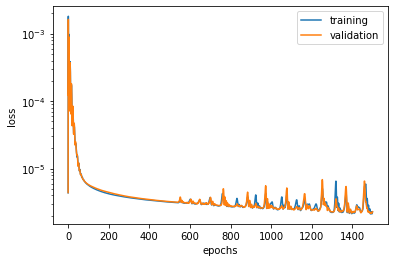

In [29]:
import matplotlib.pyplot as plt


optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

train(dynamics, data, validation_data)

## Plot sample trajectories for given throttle, steering angle
Here we plot 2 throttle levels (0.4 and 0.8) and 3 streering angles (-0.5 i.e. right, 0 i.e. straight & 0.5 i.e. left)

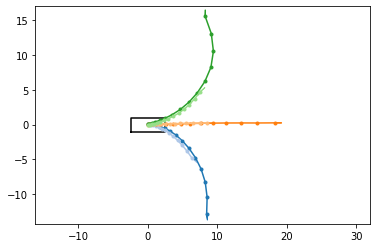

In [30]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()
    
visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Compute the reward

In [33]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.REWARD_WEIGHTS)
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards


obs = env.reset()

print(obs)

print("Reward of a sample transition:", 
      reward_model(torch.Tensor(obs["observation"]).unsqueeze(0), torch.Tensor(obs["desired_goal"])))

{'observation': array([ 0.        ,  0.        , -0.        , -0.        , -0.70095411,
       -0.71320637]), 'achieved_goal': array([ 0.        ,  0.        , -0.        , -0.        , -0.70095411,
       -0.71320637]), 'desired_goal': array([-2.600000e-01, -1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17, -1.000000e+00])}
Reward of a sample transition: tensor([-0.5672])


## Using CEM to plan trajectory

In [34]:
def cem_planner(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = action_mean + action_std * torch.randn(horizon, population, action_size)
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=5)
        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean, action_std = best_actions.mean(dim=1, keepdim=True), best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)
  
  
# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])

print("Planned action:", action)

Planned action: tensor([ 0.9327, -0.6175])


## Let's visualize the plan

In [38]:
env = gym.make("parking-v0")
env = gym.wrappers.Monitor(env, './video', force=True, video_callable=lambda episode: True)
for episode in trange(3, desc="Test episodes"):
    obs, done = env.reset(), False
    while not done:
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0])
        obs, reward, done, info = env.step(action.numpy())
env.close()
show_video()